In [2]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from river.decomposition import OnlineDMD
from river.preprocessing import Hankelizer
from river.utils import Rolling

Rolling.learn_one = Rolling.update
sys.path.append("../")

from functions.chdsubid import SubIDDriftDetector  # noqa: E402
from functions.plot import plot_chd  # noqa: E402
from functions.preprocessing import hankel  # noqa: E402

In [3]:
%load_ext autoreload
%autoreload 2

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


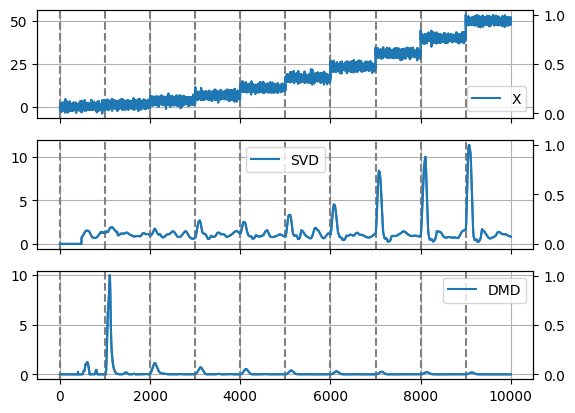

In [4]:
# Load reference scores in long list format
scores_ref_ = np.recfromtxt("data/.synthetic-steps/scores.txt").reshape(
    -1, 10000
)

# Iterate over all example datasets
n_datasets = 5
for n_d in range(n_datasets):
    # Read data
    X = np.recfromtxt(f"data/.synthetic-steps/y{n_d}.txt")

    # Take batches from scores_ref list based on length of X
    scores_ref = scores_ref_[n_d, :]

    hn = 80
    hankelizer = Hankelizer(hn)

    # Initialize Transformer
    r = 2
    init_size = 300
    odmd = OnlineDMD(r=r, initialize=init_size, w=1.0)
    # Using Rolling requires scaler to be added
    odmd = Rolling(
        OnlineDMD(
            r=r, initialize=init_size, w=1.0, exponential_weighting=False
        ),
        1000,
    )
    # Initialize Drift Detector
    ref_size = 100
    test_size = 100
    subid_dmd = SubIDDriftDetector(
        odmd,
        ref_size=ref_size,
        test_size=test_size,
        grace_period=init_size + ref_size,
    )

    # Build pipeline
    pipeline = hankelizer | subid_dmd

    # Prepare arrays for storing results
    svs_clean = np.zeros((X.shape[0], 2, 2), dtype=float)
    scores_dmd = np.zeros(X.shape[0], dtype=float)
    modes = np.empty((X.shape[0], hn, 2), dtype=float)
    mean_modes = np.empty(X.shape[0], dtype=float)
    svs = np.zeros((X.shape[0], 2, 2), dtype=float)
    us = np.zeros((X.shape[0], hn, 2), dtype=float)

    # Run pipeline
    for i, (x) in enumerate(X):
        if i % 1000 == 0:
            print(i)

        pipeline.learn_one({"x": x})

        scores_dmd[i] = subid_dmd.score
        if hasattr(subid_dmd.subid, "modes"):
            modes[i, :, :] = subid_dmd.subid.modes
            mean_modes[i] = modes[i, :, :].mean()
            svs[i, :, :] = subid_dmd.subid._svd._S
            us[i, :, :] = subid_dmd.subid._svd._U

    fig, axs = plot_chd(
        [X, scores_dmd, scores_ref],
        range(1000, X.shape[0], 1000),
        ["X", "DMD", "SVD"],
        normalize=True,
    )

    fig_name = (
        f"results/.synthetic-steps/y{n_d}-chd_r{r}-"
        f"{f'roll_{odmd.window_size}' if isinstance(odmd, Rolling) else 'noroll'}-"
        f"dmd_w{odmd.w}-h{hn}.png"
    )
    fig.savefig(fig_name)

In [17]:
hX = hankel(X, hn)

svs_batch = np.zeros((hX.shape[0], 2), dtype=float)
us_batch = np.zeros((hX.shape[0], 80, 2), dtype=float)
for i in range(0, hX.shape[0], 300):
    if len(hX.shape) > 1 and r < hX.shape[1]:
        u, s, _ = sp.sparse.linalg.svds(
            hX[i : i + 300].T, k=r, return_singular_vectors="u"
        )
    else:
        u, s, v = np.linalg.svd(hX[i : i + 300], full_matrices=False)
    svs_batch[i : i + 300, :] = s
    us_batch[i : i + 300, :] = u

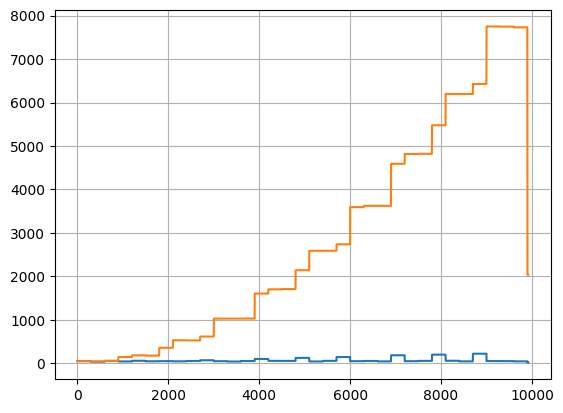

In [18]:
plt.plot(svs_batch)
plt.grid()

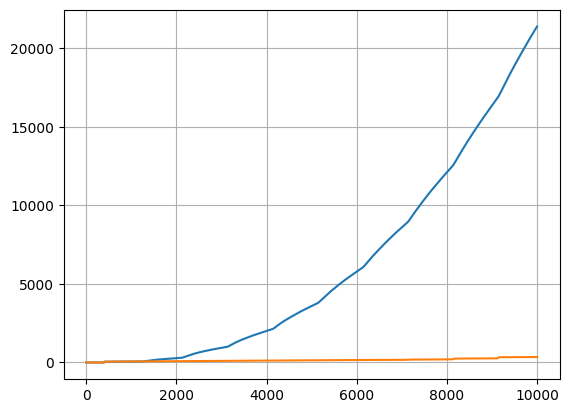

In [15]:
# Flatten last two dims of svs
# svs = svs.reshape(-1, 2)
plt.plot(np.array(svs[:, 1, :]))
plt.grid()

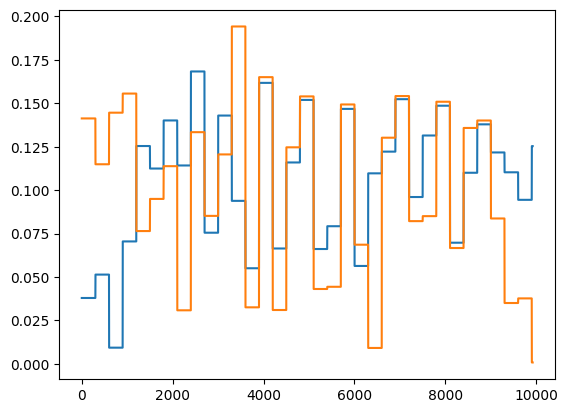

In [19]:
plt.plot(np.abs(us_batch[:, :2, 0]))

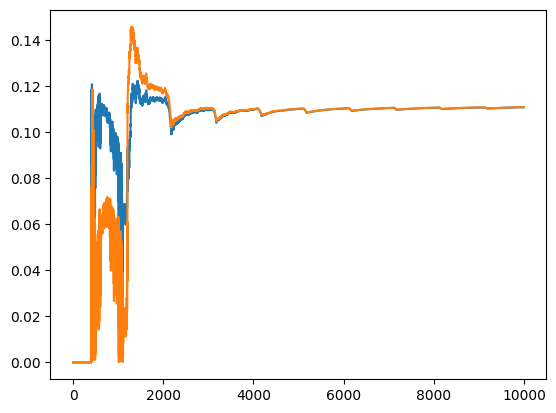

In [20]:
plt.plot(np.abs(us[:, :2, 0]))